In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import random
import time
import numpy as np
import tensorflow as tf
import cv2
import model
import utils
import pickle
import gc
from utils import decode_sparse_tensor, sparse_tuple_from

/home/xmj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


38


In [2]:
# 加载word tocken
word2idx = pickle.load(open('./word2idx3.pkl', 'rb'))
idx2word = pickle.load(open('./idx2word3.pkl', 'rb'))
temp_arr = []

In [3]:
def random_cut(image, w=800, h=40):
    ih, iw = image.shape
    x_start = random.randint(0, iw - w)
    y_start = random.randint(0, ih - h)
    return image[y_start:y_start+h, x_start:x_start+w]

In [4]:
def load_train_set(my_seq_len = 89, max_label_width=28, output_length = 200000):
    for key in word2idx:
        temp_arr.append(word2idx[key])
    label_max = max(temp_arr)
    label_max += 1
    print(label_max)
    #加载数据集
    cut_zhuanzhe = lambda m: m.split('\n')[0]
    file_lst = list(map(cut_zhuanzhe, open('../temp.lst').readlines()))
    np.random.shuffle(file_lst)
    start_idx = 0
    while True:
        end_idx = min(len(file_lst), start_idx + output_length)
        image_arr = []
        label_arr = []
        idx = 0
        seq_len_arr = []
        for f in file_lst[start_idx:end_idx]:
            image = cv2.imread('../'+f, 0)
        #     image = np.array(image[:,:500,:])
            label = list(map(int, f.split('/')[-1].split('_')[1].split('-')))
            while len(label) < max_label_width:
                label.append(label_max)
            image_arr.append(image)
            label_arr.append(label)
            seq_len_arr.append(my_seq_len)
            idx += 1
        start_idx +=  output_length
        if start_idx >= len(file_lst) - 10000:
            start_idx = 0    
            np.random.shuffle(file_lst)

        gc.collect()
        label_targets = [np.asarray(i) for i in label_arr]
        yield image_arr, label_targets, seq_len_arr

In [5]:
def build_model():
    num_hidden = 256
    num_layers = 1
    for key in word2idx:
        temp_arr.append(word2idx[key])
    num_classes = max(temp_arr) + 2
    print("num_classes", num_classes)
    init_learning_rate = 0.001
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(init_learning_rate,
                                               global_step,
                                               10000,
                                               0.9,
                                               staircase=True)
    inputs = tf.placeholder(tf.float32, [None, 40, None, 1])
    targets = tf.sparse_placeholder(tf.int32)
    seq_len = tf.placeholder(tf.int32, [None])
    ################################CNN###################################
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=inputs,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    # Convolutional Layer #2 and Pooling Layer #2 19
    conv2 = tf.layers.conv2d(
      inputs=conv1,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    print(pool2.get_shape())
    # Convolutional Layer #3 and Pooling Layer #3 9
    conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=128,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    conv3 = tf.layers.conv2d(
      inputs=conv3,
      filters=128,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    print(pool3.get_shape())
    conv4 = tf.layers.conv2d(
      inputs=pool3,
      filters=256,
      kernel_size=[3, 3],
      padding="valid",
      activation=tf.nn.relu)
    pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=[2,1])
    print(pool4.get_shape())
    conv5 = tf.layers.conv2d(
      inputs=pool4,
      filters=512,
      kernel_size=[3, 5],
      padding="valid",
      activation=tf.nn.relu)
    print(conv5.get_shape())
    ######################################################################
#     def lstm_cell():
#         return tf.contrib.rnn.LSTMCell(num_hidden)
#     stack = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(0, num_layers)],
#                                             state_is_tuple=True)

    # The second output is the last state and we will no use that
    features = tf.transpose(conv5, (0, 2, 1, 3))
    shape = tf.shape(features)
    features = tf.reshape(features, [shape[0], shape[1], 2*512])
    batch_s, max_timesteps = shape[0], shape[1]
#     outputs, _ = tf.nn.dynamic_rnn(stack, features, seq_len, dtype=tf.float32)
    # Reshaping to apply the same weights over the timesteps
    outputs = tf.reshape(features, [-1, 1024])
    logits = tf.layers.dense(inputs=outputs, units = num_classes)
    logits = tf.reshape(logits, [batch_s, -1, num_classes])
    # Time major
    logits = tf.transpose(logits, (1, 0, 2))
    #######################################################################

    print(logits.get_shape())
    loss = tf.nn.ctc_loss(targets, logits, seq_len, preprocess_collapse_repeated=False, ctc_merge_repeated=False)
    cost = tf.reduce_mean(loss)

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=global_step)

    # Option 2: tf.contrib.ctc.ctc_beam_search_decoder
    # (it's slower but you'll get better results)
    decoded, log_prob = tf.nn.ctc_beam_search_decoder(logits, seq_len, merge_repeated=False)

    # Accuracy: label error rate
    acc = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32), targets))
    return inputs, targets, seq_len, cost, optimizer, acc, decoded, global_step, learning_rate, log_prob

In [6]:
def do_report():
    test_feed = {inputs: train_inputs, targets: train_targets, seq_len: train_seq_len}
    dd, log_probs, accuracy = session.run([decoded[0], log_prob, acc], test_feed)
    print('acc:', 1-accuracy)
#     report_accuracy(dd, test_targets)
    # decoded_list = decode_sparse_tensor(dd)

def do_batch():
    feed = {inputs: train_inputs, targets: train_targets, seq_len: train_seq_len}
    b_cost, steps, _ = session.run([cost, global_step, optimizer], feed)
    if steps > 0 and steps % 1000 == 0:
#         do_report()
        save_path = saver.save(session, "models/ocr_fcn3.model", global_step=steps)
        #print(save_path)
    return b_cost, steps

In [7]:
try:
    del train_arr, train_labels, train_seq_arr, train_iter
    gc.collect()
except:
    None
train_iter = load_train_set(192)

In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
inputs, targets, seq_len, cost, optimizer, acc, decoded, global_step, learning_rate, log_prob = build_model()
# Initializate the weights and biases
init = tf.global_variables_initializer()
session.run(init)
saver = tf.train.Saver(tf.global_variables(), max_to_keep=10)

num_classes 1806
(?, 20, ?, 64)
(?, 10, ?, 128)
(?, 4, ?, 256)
(?, 2, ?, 512)
(?, ?, 1806)


In [ ]:
img = cv2.imread('../temp_img.jpg',0)# '../images/img_1946-1602-1553-1910-285_399816.jpg') # )'../images/img_1946-1602-1553-1910-285_399816.jpg'
print(img.shape)
h, w = img.shape
bili = 30 * 1.0 / h
aim_h = 30
aim_w = int(bili * w)
gray = img
ret, gray = cv2.threshold(gray, 126, 255, cv2.THRESH_BINARY)
img2 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
img2 = cv2.resize(img, (aim_w, aim_h))
h, w = img2.shape
img3 = np.ones([40, w], np.uint8) * 255
img3[5:35,:] = img2

(33, 1275)


In [ ]:
batch_size = 1
num_epochs = 10000
saver.restore(session, './models/ocr_fcn3.model-845000')
print('start')
for curr_epoch in range(num_epochs):
#     if curr_epoch % 10 == 1 and batch_size < 32:
#         batch_size = int(batch_size * 2) + 2
#     else:
#         batch_size = int(batch_size / 8) + 2
    train_arr, train_labels, train_seq_arr = next(train_iter)
    print("Epoch.......", curr_epoch)
    print(len(train_arr))
    train_cost = train_ler = 0
    for batch in range(int(len(train_arr)/batch_size) - 1):
        start = time.time()
        train_inputs = np.array(list(map(random_cut, train_arr[batch*batch_size:(batch+1)*batch_size])))[:,:,:,np.newaxis]
        train_targets = sparse_tuple_from(train_labels[batch*batch_size:(batch+1)*batch_size])
        train_seq_len = train_seq_arr[batch*batch_size:(batch+1)*batch_size]
        #print("get data time", time.time() - start)
        start = time.time()
        c, steps = do_batch()
        train_cost += c * batch_size
        seconds = time.time() - start
        if batch % 100 == 0:
            print("Step:", steps, ", batch seconds:", seconds,", loss:", c)
        
        try:
            if c < 0.001:
                print(c)
                break;
        except:
            print(c)
            break;
    decoded_ = session.run(decoded, feed_dict={inputs: np.array([img3[:,:,np.newaxis]]),seq_len:np.array([280])})
    output = [] #
    for v in decoded_[0][1]:
        output.append(idx2word[v])
    print(''.join(output))

INFO:tensorflow:Restoring parameters from ./models/ocr_fcn3.model-845000
start
1805
Epoch....... 0
200000
Step: 845001 , batch seconds: 0.20255613327026367 , loss: 0.005928373
Step: 845101 , batch seconds: 0.15399861335754395 , loss: 0.009458366
Step: 845201 , batch seconds: 0.15421724319458008 , loss: 0.47775587
Step: 845301 , batch seconds: 0.15620779991149902 , loss: 0.10573561
Step: 845401 , batch seconds: 0.15492868423461914 , loss: 0.15893134
Step: 845501 , batch seconds: 0.15461015701293945 , loss: 0.09067988
Step: 845601 , batch seconds: 0.15349864959716797 , loss: 0.036978647
Step: 845701 , batch seconds: 0.15533113479614258 , loss: 0.011060311
Step: 845801 , batch seconds: 0.15709280967712402 , loss: 0.084078304
Step: 845901 , batch seconds: 0.15478038787841797 , loss: 2.4156327


# 测试代码

In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
inputs, targets, seq_len, cost, optimizer, acc, decoded, global_step, learning_rate, log_prob = build_model()
saver = tf.train.Saver()
saver.restore(session, './models/ocr_fcn3.model-845000')

num_classes 1806
(?, 20, ?, 64)
(?, 10, ?, 128)
(?, 4, ?, 256)
(?, 2, ?, 512)
(?, ?, 1806)
INFO:tensorflow:Restoring parameters from ./models/ocr_fcn3.model-845000


(33, 1275, 3)


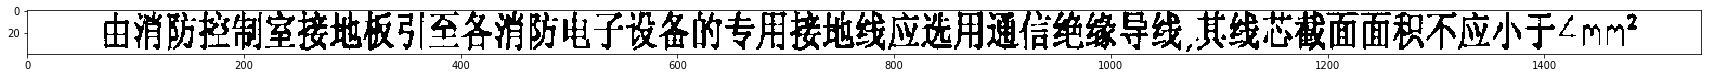

(40, 1545, 3)


In [12]:
# 使用fcn模型进行预测
img = cv2.imread('./images_result/test.jpg')# )'../images/img_1946-1602-1553-1910-285_399816.jpg'
print(img.shape)
h, w, _ = img.shape
bili = 40 * 1.0 / h
aim_h = 40
aim_w = int(bili * w)
img2 = cv2.resize(img, (aim_w, aim_h))
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
ret, gray = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
img2 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(30, 10))
plt.imshow(img2)
plt.show()
print(img2.shape)

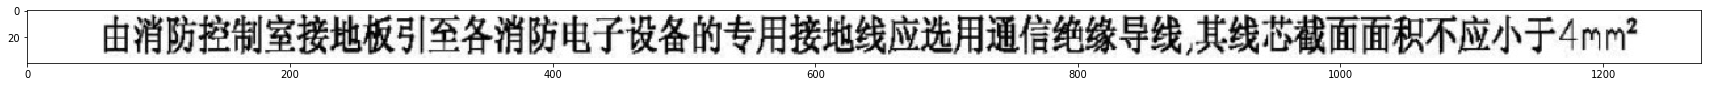

(40, 1275, 3)


In [13]:
img2 = np.ones([40, 1275, 3], np.uint8) * 255
img2[3:36,:,:] = img
plt.figure(figsize=(30, 10))
plt.imshow(img2)
plt.show()
print(img2.shape)

In [15]:
img = cv2.imread('./images_result/test.jpg',0)# '../images/img_1946-1602-1553-1910-285_399816.jpg') # )'../images/img_1946-1602-1553-1910-285_399816.jpg'
print(img.shape)
h, w = img.shape
bili = 30 * 1.0 / h
aim_h = 30
aim_w = int(bili * w)
gray = img
ret, gray = cv2.threshold(gray, 126, 255, cv2.THRESH_BINARY)
img2 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
img2 = cv2.resize(img, (aim_w, aim_h))
h, w = img2.shape
img3 = np.ones([40, w], np.uint8) * 255
img3[5:35,:] = img2

(33, 1275)


In [16]:
decoded_ = session.run(decoded, feed_dict={inputs: np.array([img3[:,:,np.newaxis]]),seq_len:np.array([280])})

In [17]:
output = [] #
for v in decoded_[0][1]:
    output.append(idx2word[v])
print(''.join(output))

由消防控制室接蝴板引至各消防电子设备的专用接地线应选通信绝缘导线,其线芯截面面树不应于4m㎡


In [ ]:
print(decoded_[0])

In [ ]:
plt.figure(figsize=(30, 10))
plt.imshow(img2)
plt.show()